ChEn-3170: Computational Methods in Chemical Engineering Fall 2021 UMass Lowell; Prof. V. F. de Almeida **10Nov20**

# 15. Multiple Reactions at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Jmtrx}{\boldsymbol{\mathsf{J}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\Xmtrx}{\boldsymbol{\mathsf{X}}}
  \newcommand{\Kmtrx}{\boldsymbol{\mathsf{K}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \DeclareMathOperator{\partialx}{\partial_\xvec}
  \newcommand{\Kcal}{\mathcal{K}}
  \newcommand{\Kcalvec}{\boldsymbol{\mathcal{K}}}
  \newcommand{\epsvec}{\boldsymbol{\varepsilon}}
$

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data](#idata)
* [Analyze Reaction Mechanism](#analyze)
* [Plot Equilibrium Vector Function](#eqfunc)
* [Solve for Equilibrium](#solve)
* [Plot Equilibrium Point](#eqpt)
---

## [Introduction](#toc)<a id="intro"></a>
In the previous [notebook](https://nbviewer.jupyter.org/github/dpploy/chen-3170/blob/master/notebooks/14-single-reaction-equilibrium.ipynb), a general method for finding equilibrium molar fractions for a single chemical reaction in equilibrium was developed (any number of chemical species and any stoichiometry). Here we further extend the method for a reaction mechanism involving **multiple reactions**.
Newton's method for computing roots of multiple non-linear equations, $\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)=\zerovec$, is described in the course notes OneNote [ChEn-3170-nonlinalg-c](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Ev5yIex-I9RNkorM9hn0NNYBEtRm0zI6zFPejo1qmibqpQ?e=K67TIN).

In the case of multiple reactions we write the equilibrium functions (vector-valued function) as a vector with components

\begin{equation*}
\Kcal_i(\xvec)= K_{x,i} - \prod\limits_{j=1}^N\, x_j^{S_{i,j}} = \zerovec,
\end{equation*}

where $i$ is the index of each reaction.

In [1]:
'''Equilibrium function vector'''

def keq_function(x_vec, keq_cte_vec, stoic_mtrx):
    
    n_reactions = keq_cte_vec.size
    n_species   = x_vec.size
    
    # Sanity check
    assert n_reactions == stoic_mtrx.shape[0]
    assert n_species   == stoic_mtrx.shape[1]
    
    prod_vec = np.ones(n_reactions, dtype=np.float64)
    
    for i in range(n_reactions):
        prod_vec[i] = np.prod(x_vec ** stoic_mtrx[i,:])
       
    keq_vec = keq_cte_vec - prod_vec
    
    return keq_vec

The molar fractions vector is a function of the normalized extent of reactions vector

\begin{equation*}
\xvec(\widehat{\epsvec}) = \frac{\xvec^{(0)} + \Smtrx^\top\widehat{\epsvec}\,}{1+\sum\limits_j (\Smtrx^\top\widehat{\epsvec})_j} ,
\end{equation*}

where $\xvec^{(0)}$ is the vector of initial molar fractions (or reference).

In [2]:
'''Molar fractions function'''

def molar_fractions(ext_hat_vec, x_vec_0, stoic_mtrx):
    
    # Sanity check
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs(1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()) >= 1e-8
    
    x_vec = ( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec ) / \
            ( 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum() )
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution vector requires the value of 
$\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$ at different values of $\widehat{\epsvec}$ and the total derivative

\begin{equation*}
\partial_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 
                       \partialx\Kcalvec \, \partial_{\widehat{\epsvec}}\xvec ,
\end{equation*}

which is matrix product. The molar fraction gradient is computed as a product of three matrices

\begin{equation*}
 \partialx\Kcalvec = - \Kmtrx\,\Smtrx\,\Xmtrx^{-1} ,
\end{equation*}

that is,

\begin{equation*}
 \Kmtrx = 
  \begin{pmatrix}
   K_{x,1} & 0       & \dots  & 0      \\
   0       & K_{x,2} & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & K_{x,m}
\end{pmatrix}, 
\ \ \ 
\Smtrx = 
\begin{pmatrix}
S_{1,1} & S_{1,2} & \dots  & S_{1,n} \\
S_{2,1} & S_{2,2} & \dots  & S_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
S_{m,1} & S_{m,2} & \dots  & S_{m,n}
\end{pmatrix},
\ \ \ 
 \Xmtrx = 
  \begin{pmatrix}
   x_1 & 0       & \dots  & 0      \\
   0       & x_2 & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & x_n
\end{pmatrix} .
%
\end{equation*}

In [3]:
'''Gradient wrt to molar fractions of the equilibrium function'''

def grad_x_keq_function(x_vec, keq_cte_vec, stoic_mtrx):
    
    import numpy as np
    
    # build the K matrix
    k_mtrx = np.diag(keq_cte_vec)
    
    # correct for division by a very small number (initial null charge; final fully consumed species)
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    max_x = x_vec_local.max()
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    x_mtrx_inv = np.diag(x_vec_inv)
    
    grad_mtrx = - k_mtrx @ stoic_mtrx @ x_mtrx_inv
    
    return grad_mtrx

The molar fraction derivative is

\begin{equation*}
\partial_{\widehat{\epsvec}}\xvec = \frac{\Smtrx^\top - \xvec\otimes\sum_j\Smtrx_{\bullet,j} }{1+\sum_j (\Smtrx^\top\widehat{\epsvec})_j}
\end{equation*}

In [4]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions(ext_hat_vec, x_vec, stoic_mtrx):
    
    a  = 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()
    
    dext_x_mtrx = ( stoic_mtrx.transpose() - np.outer(x_vec, stoic_mtrx.sum(1)) ) / a
    
    return dext_x_mtrx

## [Algorithm](#toc)<a id="algo"></a>

Given $\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$, find the root

\begin{equation*}
\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\epsvec}_0$.
Compute the updates

\begin{equation*}
d_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec}_{k-1})\bigr) \, \delta \widehat{\epsvec}_k = - \Kcalvec\bigl(\xvec(\widehat{\epsvec}_{k-1})\bigr) 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\epsvec}_k = \widehat{\epsvec}_{k-1} + \delta \widehat{\epsvec}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\norm{\delta\widehat{\epsvec}_k} \le 10^{-8}$ and $\norm{\Kcal\bigl(\xvec(\widehat{\epsvec}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [5]:
'''Newton's method'''

def newton_solve(x_vec_0, keq_cte_vec, stoic_mtrx,
                 ext_hat_vec_0=None, k_max=30, tolerance=1.0e-10, verbose=True):
    
    try:
        from chen_3170.toolkit import solve
    except ModuleNotFoundError:
        assert False, 'You need to provide your own solve function here. Bailing out.'
        
    try:    
        from chen_3170.toolkit import universal_solve   
    except ModuleNotFoundError:
        assert False, 'You need to provide your own lu_factorization function here. Bailing out.'
        
    try:    
        from chen_3170.toolkit import matrix_rank    
    except ModuleNotFoundError:
        assert False, 'You need to provide your own matrix_rank function here. Bailing out.'
    
    import numpy as np
    
    if ext_hat_vec_0 is None:
        ext_hat_vec_0 = np.zeros(keq_cte_vec.size,dtype=np.float64)
    
    # Other initialization
    delta_vec_k = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64)
    keq_vec_k   = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64) # equilibrium function initial value
    ext_hat_vec = np.copy(ext_hat_vec_0)

    if verbose is True:
        print('\n')
        print('**********************************************************')
        print("               Newton's Method Iterations                 ")
        print('**********************************************************')
        print("k | |K(e_k)|  | |K'(e_k)| | |del e_k| |   |e_k|   | convg|")
        print('----------------------------------------------------------')

    import math
    k = 0
    
    while (np.linalg.norm(delta_vec_k) > tolerance or np.linalg.norm(keq_vec_k) > tolerance) and k <= k_max:
        
        # compute the molar fractions
        x_vec = molar_fractions(ext_hat_vec, x_vec_0, stoic_mtrx) 
        
        # compute the equilibrium function
        keq_vec_k = keq_function(x_vec, keq_cte_vec, stoic_mtrx)
        
        # compute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_keq_function(x_vec, keq_cte_vec, stoic_mtrx)
        
        # compute the extent of reaction derivative of the molar fraction
        #old d_ext_x = d_ext_molar_fractions(ext_hat_vec, x_vec_0, stoic_mtrx)
        d_ext_x = d_ext_molar_fractions(ext_hat_vec, x_vec, stoic_mtrx)
        
        # form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = grad_x_k @ d_ext_x # Jacobian matrix
        
        # compute the Newton update    
        delta_vec_k_old = delta_vec_k # save the old update for convergence monitoring
        
        j_mtrx = d_ext_keq_k # alias for the Jacobiam matrix
        
        b_vec  = - keq_vec_k # alias for the RHS vector
        
        # sanity check
        assert j_mtrx.shape[0] == j_mtrx.shape[1]
        
        # full rank option
        if matrix_rank(j_mtrx) == min(j_mtrx.shape):
            delta_vec_k = solve(j_mtrx, b_vec, pivoting_option='partial')
        # rank deficient option
        else:         
            delta_vec_k = universal_solve(j_mtrx, b_vec, epsilon_min=-4, pivot_tol=1e-5, zero_tol=1e-5)

        # make sure iterates are moving towards root
        keq_vec_k_old = keq_vec_k
        step_size = 1.0
        x_vec = molar_fractions(ext_hat_vec + delta_vec_k, x_vec_0, stoic_mtrx)
        keq_vec_k = keq_function(x_vec, keq_cte_vec, stoic_mtrx)
        
        n_steps_max = 10
        n_steps = 0
        while np.linalg.norm(keq_vec_k) > np.linalg.norm(keq_vec_k_old) and n_steps <= n_steps_max:
            step_size *= 0.5
            x_vec = molar_fractions(ext_hat_vec + step_size * delta_vec_k, x_vec_0, stoic_mtrx)
            keq_vec_k = keq_function(x_vec, keq_cte_vec, stoic_mtrx)
            n_steps += 1
        if step_size != 1.0:
            print('Step_size = ',step_size)
        
        # compute the update to the root candidate
        ext_hat_vec += step_size * delta_vec_k
        
        if k > 0:
            if np.linalg.norm(delta_vec_k) != 0.0 and np.linalg.norm(delta_vec_k_old) != 0.0:
                convergence_factor = math.log(np.linalg.norm(delta_vec_k),10) / math.log(np.linalg.norm(delta_vec_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+11.3e %+11.3e %+11.3e %+11.3e %4.2f'%\
                  (k, np.linalg.norm(keq_vec_k), np.linalg.norm(d_ext_keq_k), np.linalg.norm(delta_vec_k), np.linalg.norm(ext_hat_vec), convergence_factor))

    if verbose is True:
        print('**********************************************************') 
        print('Root = ',[round(r,4) for r in ext_hat_vec])
    
    return ext_hat_vec

## [Input Data](#toc)<a id="idata"></a>

Using the ammonia oxidation reaction mechanism from the input file: `data/ammonia-rxn.txt` 

In [6]:
!cat data/ammonia-rxn.txt

#
# Ammonia oxidation mechanism
#
# format
..str:float
4 NH3 + 5 O2        <=> 4 NO  + 6 H2O : K_x = 2.5e+02
4 NH3 + 3 O2        <=> 2 N2  + 6 H2O : K_x = 1.8e+02
4 NH3 + 6 NO        <=> 5 N2  + 6 H2O : K_x = 1.099692e+02
2 NO  + 1 O2        <=> 2 NO2         : K_x = 1e+02
2 NO                <=> 1 N2  + 1 O2  : K_x = 8.485281e-01
1 N2  + 2 O2        <=> 2 NO2         : K_x = 1.178511e+02
4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O : K_x = 1.296e+02


In [7]:
'''Import the ammonia reaction mechanism'''

try:    
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'
    
# read species, reactions, equilibrium constants and build the stoichiometric matrix
(species, reactions, stoic_mtrx, keq_cte, dummy) = reaction_mechanism('data/ammonia-rxn.txt')

species= ['N2', 'O2', 'NH3', 'NO', 'NO2', 'H2O']

r0 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O
r1 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O
r2 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O
r3 :  2 NO  + 1 O2        <=> 2 NO2
r4 :  2 NO                <=> 1 N2  + 1 O2
r5 :  1 N2  + 2 O2        <=> 2 NO2
r6 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O
n_reactions = 7

K_x eq =  [250.    180.    109.969 100.      0.849 117.851 129.6  ]

matrix shape = (7, 6)


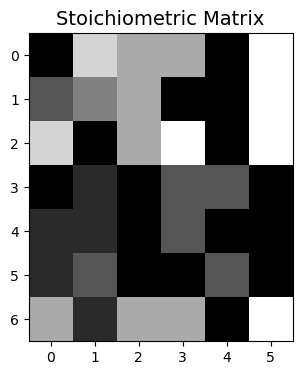


stoic_mtrx=
 [[ 0. -5. -4.  4.  0.  6.]
 [ 2. -3. -4.  0.  0.  6.]
 [ 5.  0. -4. -6.  0.  6.]
 [ 0. -1.  0. -2.  2.  0.]
 [ 1.  1.  0. -2.  0.  0.]
 [-1. -2.  0.  0.  2.  0.]
 [ 4. -1. -4. -4.  0.  6.]]

mole balance vector =
 [ 1.  1.  1. -1.  0. -1.  1.]


In [8]:
'''Info on the data'''

import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)

print('species=',species)

from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')

keq_cte_vec = np.array(keq_cte)
print('K_x eq = ',keq_cte_vec)
print('')

from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix')
print('')
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)
print('')
print('mole balance vector =\n', stoic_mtrx.sum(1))

The following reference molar fraction $\xvec^{(0)}$ is given:

  Reference Molar Fraction    | Parameter    | Value |
------------------------------|--------------|-------|
 NO  | $x_{NO}$     | 0.1   |
 N2  | $x_{N2}$     | 0.1   |
 NO2 | $x_{NO2}$    | 0.0   |
 O2  | $x_{O2}$     | 0.3   |
 H2O | $x_{H2O}$    | 0.0   |
 NH3 | $x_{NH3}$    | 0.5   |

In [9]:
'''Set reference molar fraction'''

import numpy as np
x_dict_0 = {'NO':0.1,'N2':0.1,'NO2':0.0,'O2':0.3,'H2O':0.0,'NH3':0.5}

x_vec_0 = np.zeros(len(species),dtype=np.float64)
for i in range(len(species)):
    x_vec_0[i] = x_dict_0[species[i]]
    
# Consistency check
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12,'sum = %r'%(np.sum(x_vec_0))
assert np.all(x_vec_0 >=0.0)

In [10]:
'''Bounds on extents of reaction'''

ext_hat_vec_min = np.zeros(len(reactions), dtype=np.float64)
ext_hat_vec_max = np.zeros(len(reactions), dtype=np.float64)

for (i, reaction) in enumerate(reactions):

    (ids,) = np.where(stoic_mtrx[i,:]>0) # products
    ext_hat_min = np.max(-x_vec_0[ids]/np.abs(stoic_mtrx[i,ids]))

    (ids,) = np.where(stoic_mtrx[i,:]<0) # reactants
    ext_hat_max = np.min( x_vec_0[ids]/np.abs(stoic_mtrx[i,ids]))

    # reduce the ends of the interval by 0.5% to avoid infinite values in the equilibrium function
    dext = (ext_hat_max - ext_hat_min)*.005
    ext_hat_min += dext
    ext_hat_max -= dext
    
    ext_hat_vec_min[i] = ext_hat_min
    ext_hat_vec_max[i] = ext_hat_max

np.set_printoptions(precision=2,threshold=100,edgeitems=5)
print('ext_hat_min = ',ext_hat_vec_min)
print('ext_hat_max = ',ext_hat_vec_max)

ext_hat_min =  [ 3.00e-04  5.00e-04  8.33e-05  2.50e-04 -9.93e-02  5.00e-04  1.25e-04]
ext_hat_max =  [0.06 0.1  0.02 0.05 0.05 0.1  0.02]


## [Analyze Reaction Mechanism](#toc)<a id="analyze"></a>

In [11]:
'''Check the rank of the stoichiometric matrix'''

try:    
    from chen_3170.toolkit import matrix_rank    
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

rank = matrix_rank(stoic_mtrx)
print('stoic_mtrx m x n =',stoic_mtrx.shape)
print('stoic_mtrx rank =',rank)

if rank < min(stoic_mtrx.shape):
    print('WARNING: stoichiometric matrix is rank deficient!')

stoic_mtrx m x n = (7, 6)
stoic_mtrx rank = 3


## [Plot Equilibrium Vector Function](#toc)<a id="eqfunc"></a>

Plot equilibrium vector function for the reaction mechanism. 

In [12]:
'''Function: plot equilibrium function'''

def plot_keq_function(ext_hat_vec_min, ext_hat_vec_max, num_pts,
                       x_vec_0, keq_cte_vec, stoic_mtrx,
                       ext_hat_vec_root=None ):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [8, 30]
    
    # number of functions to be plotted
    num_keq_functions = keq_cte_vec.size
    
    import numpy as np
    
    # allocate a matrix for all ext_hat_vec plot points (min to max)
    ext_hat_plot_pts = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for ext_hat_vec
    for i in range(num_keq_functions):
        ext_hat_plot_pts[:,i] = np.linspace(ext_hat_vec_min[i], ext_hat_vec_max[i], num_pts)
    
    # allocate a matrix for all keq_function_vec plot points
    keq_function_plot_values = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for keq_function
    for i in range(num_keq_functions):
    
        for k in range(num_pts):
            x_vec = molar_fractions( ext_hat_plot_pts[k,:], x_vec_0, stoic_mtrx ) 
            keq_function_plot_values[k,:] = keq_function( x_vec, keq_cte_vec, stoic_mtrx )
    
    # Plot keq_function_vec in subplots
    n_rows = num_keq_functions
    n_columns = 1
    # create colors for each equilibrium function
    color_ids = np.linspace(0,1,num_keq_functions)
    
    for (iplot,color_id) in zip(range(n_rows),color_ids):
        plt.subplot(n_rows,n_columns, iplot+1)
        #color = plt.cm.nipy_spectral(color_id)
        color = plt.cm.cool(color_id)
        plt.plot(ext_hat_plot_pts[:,iplot], keq_function_plot_values[:,iplot],
                 color=color,label='$K_{x,%i}=$%8.2e'%(iplot,keq_cte_vec[iplot]))
    
        plt.xlabel(r'$\hat{\varepsilon}_{%i}$'%iplot,fontsize=18)
        plt.ylabel(r'$K_{%i}(\hat{\varepsilon})$'%iplot,fontsize=18)
        plt.title(reactions[iplot],fontsize=20)
        plt.legend(loc='best',fontsize=12)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
    
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = x_max+dx*1/100
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = y_max - dy*0.1
    
        for x,spc in zip(x_vec_0,species):
            plt.text(x_text, y_text, r'$x_{%s}^{(0)}=$%8.2e'%(spc,x),fontsize=16)
            y_text -= dy*0.11
    
        if ext_hat_vec_root is not None:
            
            e_root = ext_hat_vec_root[iplot]
            plt.plot(e_root, 0.0,'r*',label='root',markersize=14)
               
            (x_min,x_max) = plt.xlim()
            dx = abs(x_max-x_min)
            x_text = e_root + dx*0.01
    
            (y_min,y_max) = plt.ylim()
            dy = abs(y_max-y_min)
            y_text = 0.0 + dy*0.01
    
            plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%e_root,fontsize=16)
       
        plt.grid(True)
        plt.show()
        print('')
    
    return

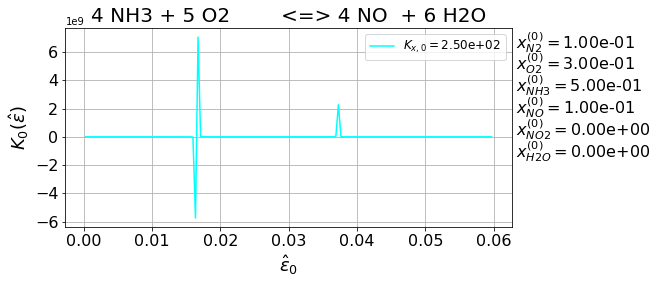

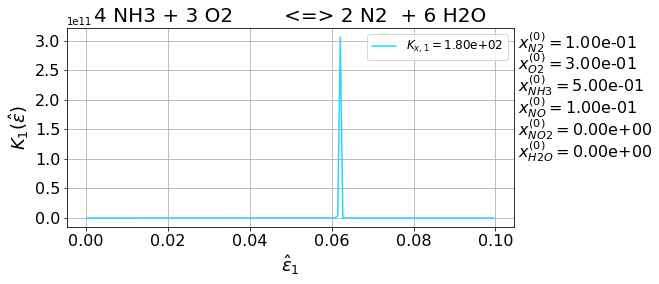

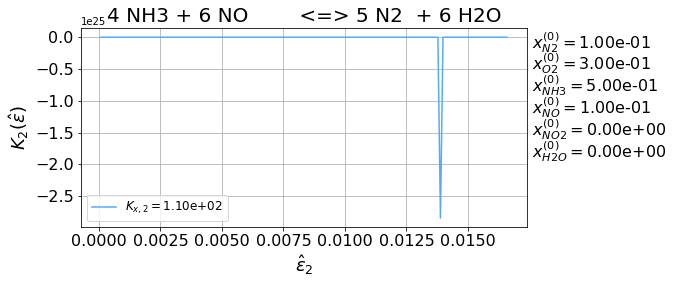

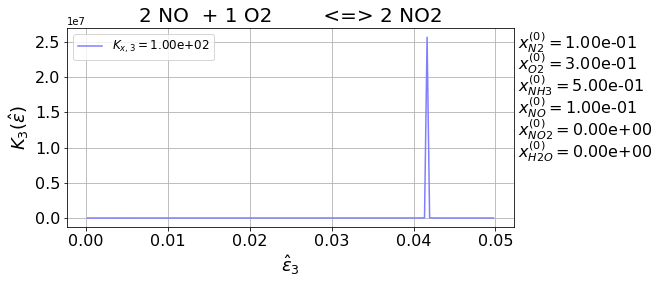

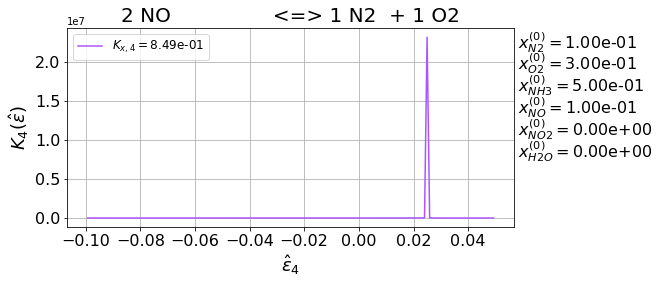

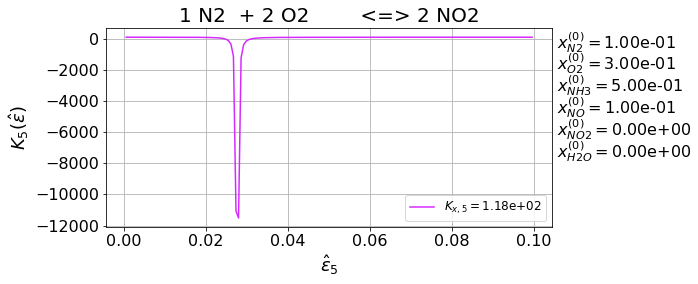

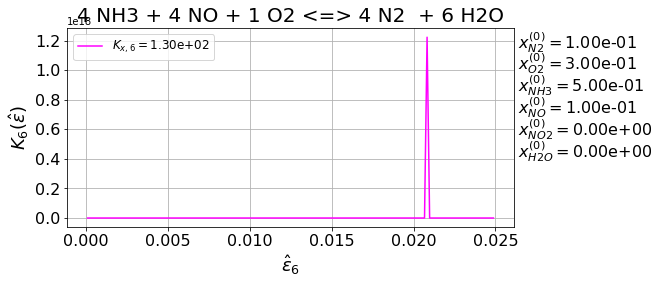

In [13]:
'''Plot equilibrium vector function'''

n_pts = 160

plot_keq_function(ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                  x_vec_0, keq_cte_vec, stoic_mtrx)

## [Solve for Equilibrium](#toc)<a id="solve"></a>

Solve for equilibrium for the first sub-mechanism. 

In [14]:
'''Find root'''

ext_hat_vec_0 = (ext_hat_vec_min + ext_hat_vec_max)/3.5

k_max = 50
tolerance = 5.0e-5

ext_hat_vec = newton_solve(x_vec_0, keq_cte_vec, stoic_mtrx,
                           ext_hat_vec_0, k_max, tolerance)



**********************************************************
               Newton's Method Iterations                 
**********************************************************
k | |K(e_k)|  | |K'(e_k)| | |del e_k| |   |e_k|   | convg|
----------------------------------------------------------
 1  +2.133e+02  +3.715e+05  +9.905e-03  +5.321e-02 0.00
 2  +9.235e+01  +3.831e+05  +3.484e-03  +5.572e-02 1.23
 3  +1.335e+01  +4.331e+05  +9.959e-04  +5.647e-02 1.22
 4  +2.730e-01  +4.535e+05  +4.680e-05  +5.650e-02 1.44
 5  +1.312e-04  +4.556e+05  +1.429e-06  +5.650e-02 1.35
 6  +4.123e-05  +4.556e+05  +8.533e-10  +5.650e-02 1.55
**********************************************************
Root =  [0.0142, 0.0268, 0.0055, 0.0243, -0.0133, 0.0378, 0.0071]


In [15]:
'''Compute equilibrium molar fractions'''

x_vec = molar_fractions(ext_hat_vec, x_vec_0, stoic_mtrx)

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species):
    print('%5s = %5.3e (%4.1f%%)'%(spc,x,round(x*100,1)))

# Sanity check
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10


Equilibrium mole fractions:

   N2 = 1.599e-01 (16.0%)
   O2 = 2.883e-02 ( 2.9%)
  NH3 = 2.881e-01 (28.8%)
   NO = 7.372e-02 ( 7.4%)
  NO2 = 1.252e-01 (12.5%)
  H2O = 3.243e-01 (32.4%)



## [Plot Equilibrium Point](#toc)<a id="eqpt"></a> 

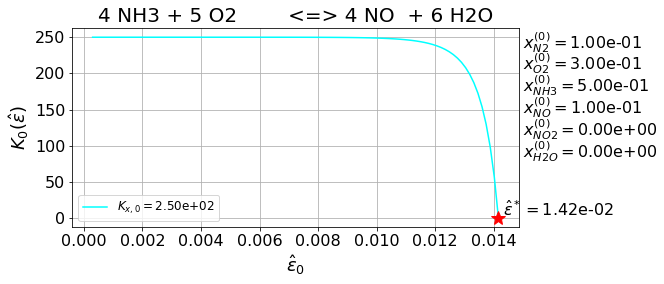

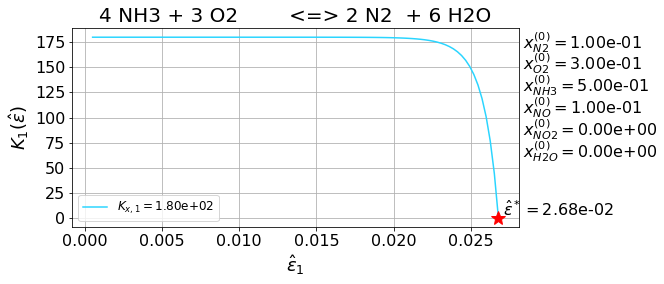

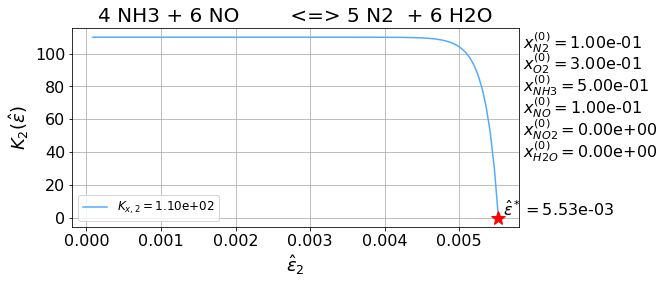

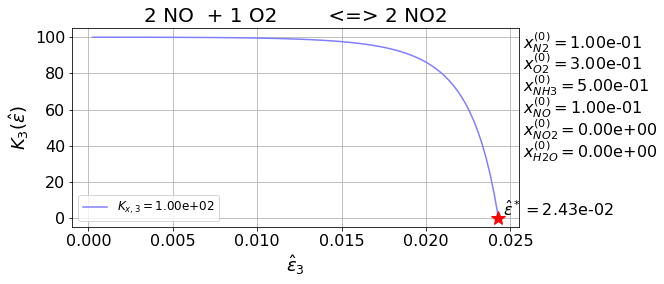

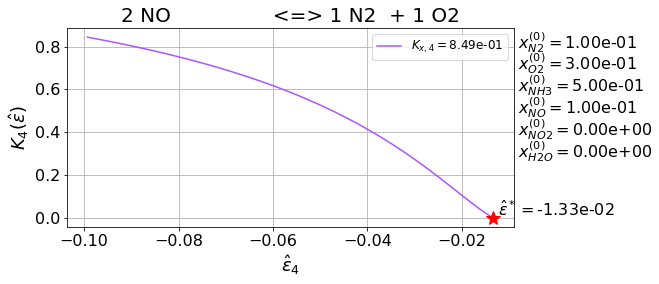

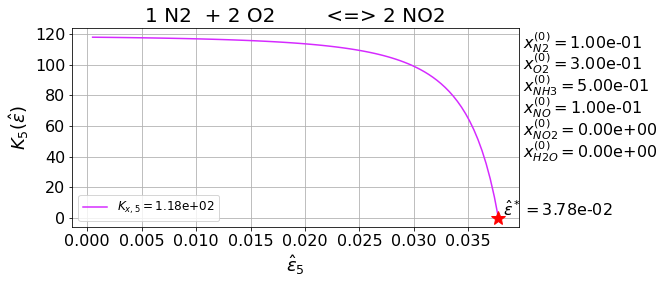

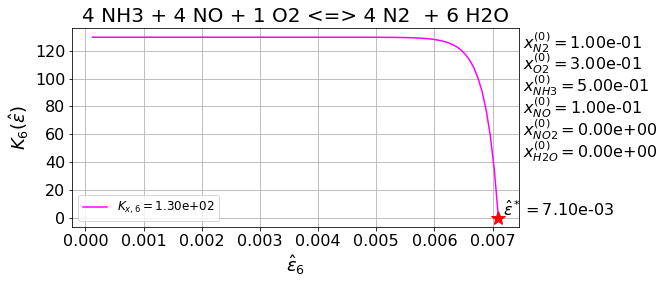

In [16]:
'''Plot equilibrium vector function'''

n_pts = 100

plot_keq_function(ext_hat_vec_min, ext_hat_vec, n_pts, 
                  x_vec_0, keq_cte_vec, stoic_mtrx, ext_hat_vec)